In [59]:
import requests
import json
import pandas as pd
from datetime import datetime, timezone
import matplotlib.pyplot as plt

def get_data():
    # Setze die API-Endpunkt-URL
    api_url = "https://api.awattar.de/v1/marketdata"
    df = pd.DataFrame()

    # Erstelle die Parameter für "start" und "end" in Millisekunden
    start_timestamp = int(datetime(2023, 1, 1).timestamp() * 1000)
    end_timestamp = int(datetime(2023, 1, 31).timestamp() * 1000)

    # Erstelle die Parameter für die GET-Anfrage
    params = {
        'start': start_timestamp,
        'end': end_timestamp
    }

    # Sende die GET-Anfrage an die API
    response = requests.get(api_url, params=params)

    # Überprüfe die Antwort der API
    if response.status_code == 200:
        data = response.json()

        return pd.DataFrame(data["data"])

        # Speichere die JSON-Daten in einer Datei
        # with open('api_response.json', 'w') as json_file:
        #     json.dump(data, json_file, indent=4)
    else:
        print(f"Fehler bei der Anfrage. Statuscode: {response.status_code}")
        return df

start_timestamp      int64
end_timestamp        int64
marketprice        float64
unit                object
date                object
dtype: object


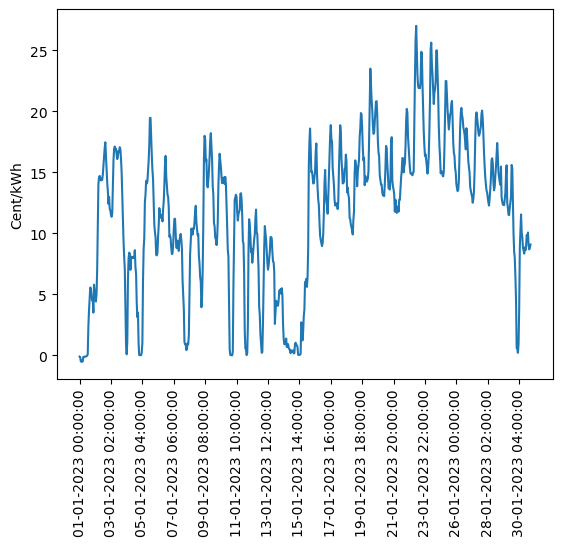

In [60]:
df = get_data()
assert not df.empty

df["marketprice"] = (df["marketprice"] * 0.1).round(2)
df["unit"] = "Cent/kWh"
df["date"] = df["start_timestamp"].apply(lambda epoch: datetime.fromtimestamp(epoch / 1000, tz=timezone.utc).strftime('%d-%m-%Y %H:%M:%S'))
df.drop(0, axis=0, inplace=True)
# df = df.head(100)

print(df.dtypes)
plt.plot(df["date"], df["marketprice"])
plt.ylabel(df["unit"].iloc[0])
plt.xticks(df["date"][::50], rotation=90)
plt.show()

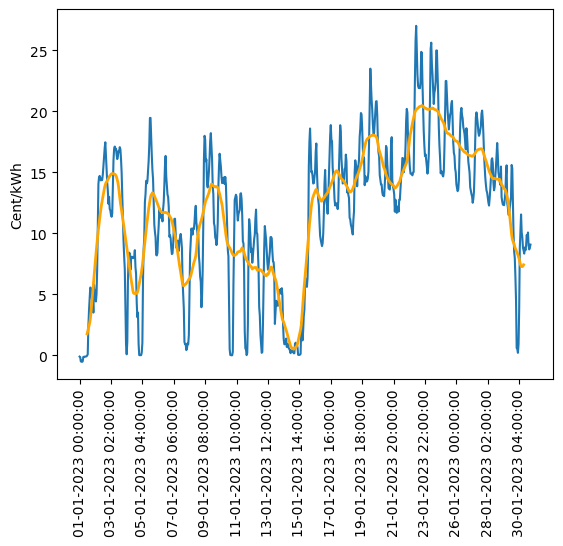

In [61]:
rolling_mean = df["marketprice"].rolling(window=24, center=True).mean()
# df = df.head(100)

plt.plot(df["date"], df["marketprice"], label='Original Data', linestyle='-')
plt.plot(df["date"], rolling_mean, label='Rolling Average', linestyle='-', linewidth=2, color='orange')

plt.ylabel(df["unit"].iloc[0])
plt.xticks(df["date"][::50], rotation=90)
plt.show()